In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json

#Описание данных
Структура данных:
* used_id -- id игрока
* media_source -- источник установки. Organic - пришедший к нам без рекламы (через стор); ad-traffic - пришёл к нам по рекламе.
* client_time -- время события
* event_name -- имя события
* event_data -- доп. данные описывающие событие. Для некоторых ивентов могут отсутствовать. Для каждого event_name структура event_data стандартизированна
* session_index -- порядковый номер сессии, в которую это событие произошло
* game_status -- статус прогресса пользователя на момент любого события: 
    1. Coins - кол-во монет;
    2. freeRounds/freeUndo/freeWildCard/freeAddCards - кол-во бесплатных бустеров на руках в текущий;
    3. level - последний открытый уровень (уникальный идентификатор уровня);
    4. bet - величина ставки. Остальные поля неактуальны.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kosmos_Analyst/TZ_GP.csv')
df['client_time'] =  pd.to_datetime(df['client_time'], format='%Y-%m-%d %H:%M:%S')

In [3]:
print(df.shape)
df.head()

(396099, 7)


,user_id,media_source,client_time,session_index,game_status,event_name,event_data
0,60c588d7b4d1b24b40531f29,organic,2021-06-05 07:23:06,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""Xiaomi POCO M2 Pro"",""graphicMemory""..."
1,60d34c7ab4d1b24b405324ac,organic,2021-06-05 16:33:26,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-J200G"",""graphicMemory"":2..."
2,60babef87c80da6a9442cb86,ad-traffic,2021-06-05 00:02:07,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-G781B"",""graphicMemory"":2..."
3,60bac0e912667e6a8d107731,ad-traffic,2021-06-05 00:04:29,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-T290"",""graphicMemory"":51..."
4,60babfb17c80da6a9442cb87,organic,2021-06-05 00:05:16,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-N960F"",""graphicMemory"":2..."


In [4]:
a = df[df['event_name'] == 'gladeComplete']['event_data'].copy()
a = a.reset_index(drop=True)
s = []
for i in a:
    s+=[ast.literal_eval(i)['levels']]
unique, counts = np.unique(s, return_counts=True)

#Using functions

In [5]:
# funnel visualization: https://medium.com/multiplyai/user-conversion-funnel-9d957ce3e80c
def create_funnel_df(df, steps, from_date=None, to_date=None, step_interval=0):
    """
    Function used to create a dataframe that can be passed to functions for generating funnel plots.
    """
    # filter df for only events in the steps list
    df = df[['user_id', 'event_name', 'client_time']]
    df = df[df['event_name'].isin(steps)]

    values = []
    # for the rest steps, create a df and filter only for that step
    for i, step in enumerate(steps):
      if i == 0:
          dfs = {}
          dfs[step] = df[df['event_name'] == step] \
              .sort_values(['user_id', 'client_time'], ascending=True) \
              .drop_duplicates(subset=['user_id', 'event_name'], keep='first')

          # filter df of 1st step according to dates
          if from_date:
              dfs[step] = dfs[step][(dfs[step]['time'] >= from_date)]

          if to_date:
              dfs[step] = dfs[step][(dfs[step]['time'] <= to_date)]

      else:
          dfs[step] = df[df['event_name'] == step]
          # outer join with previous step
          merged = pd.merge(dfs[steps[i - 1]], dfs[step], on='user_id', how='outer')

          # keep only rows for which the distinct_ids appear in the previous step
          valid_ids = dfs[steps[i - 1]]['user_id'].unique()
          merged = merged[merged['user_id'].isin(valid_ids)]
          # keep only events that happened after previous step and sort by time
          merged = merged[merged['client_time_y'] >=
                          merged['client_time_x']].sort_values('client_time_y', ascending=True)
          # take the minimum time of the valid ones for each user
          merged = merged.drop_duplicates(subset=['user_id', 'event_name_x', 'event_name_y'], keep='first')
          # keep only the necessary columns and rename them to match the original structure
          merged = merged[['user_id', 'event_name_y', 'client_time_y']].rename({'event_name_y': 'event_name',
                                                                                'client_time_y': 'client_time'}, axis=1)
          # include the df in the df dictionary so that it can be joined to the next step's df
          dfs[step] = merged
      # append number of users to the "values" list
      values.append(len(dfs[step]))

    # create dataframe
    funnel_df = pd.DataFrame({'step': steps, 'val': values})
    # calculate percentage conversion for each step
    funnel_df['pct'] = (100 - 100 * abs(funnel_df['val'].pct_change()).fillna(0)).astype(int)
    # shift val by one to plot faded bars of previous step in background
    funnel_df['val-1'] = funnel_df['val'].shift(1)
    # calculate percentage conversion between each step and the first step in the funnel
    funnel_df['pct_from_first'] = (funnel_df['val'] / funnel_df['val'].loc[0] * 100).fillna(0).astype(int)

    return funnel_df


def group_funnel_dfs(events, steps, col):
    """
    Function used to create a dict of funnel dataframes used to generate a stacked funnel plot.
    """
    dict_ = {}
    
    # get the distinct_ids for each property that we are grouping by
    ids = dict(events.groupby([col])['user_id'].apply(set))

    for entry in events[col].dropna().unique():
        ids_list = ids[entry]
        df = events[events['user_id'].isin(ids_list)].copy()
        if len(df[df['event_name'] == steps[0]]) > 0:
           dict_[entry] = create_funnel_df(df, steps)

    return dict_


def plot_stacked_funnel(events, steps, col=None, from_date=None, to_date=None, step_interval=0):
    """
    Function used for producing a (stacked) funnel plot.
    """
    # create list to append each trace to
    # this will be passed to "go.Figure" at the end
    data = []

    # if col is provided, create a funnel_df for each entry in the "col"
    if col:
        # generate dict of funnel dataframes
        dict_ = group_funnel_dfs(events, steps, col)
        title = 'Funnel plot per {}'.format(col)
    else:
        funnel_df = create_funnel_df(events, steps, from_date=from_date, to_date=to_date, step_interval=step_interval)
        dict_ = {'Total': funnel_df}
        title = 'Funnel plot'

    for t in dict_.keys():
        trace = go.Funnel(
            name=t,
            y=dict_[t].step.values,
            x=dict_[t].val.values,
            textinfo="value+percent previous"
        )
        data.append(trace)

    layout = go.Layout(margin={"l": 180, "r": 0, "t": 30, "b": 0, "pad": 0},
                       height=400, width=1000,
                       funnelmode="stack",
                       showlegend=True,
                       hovermode='closest',
                       title='Funnel plot per {}'.format(col),
                       legend=dict(orientation="v",
                                   bgcolor='#E2E2E2',
                                   xanchor='left',
                                   font=dict(
                                       size=12)
                                   )
                       )

    return go.Figure(data, layout)

# Test 1.1 FTUE (5-7 часов)
Используя предоставленный датасет, изучите воронку обучения и в целом вступление в игру. Сформулируйте гипотезы о том, что можно улучшить, подкрепите их данными. Обучение можно считать пройденным, когда пройдена первая грядка.

In [14]:
# Построим воронку от установки до прохождения первой грядки
steps = ['appInstall', 'learning', 'gladeComplete']
fig = plot_stacked_funnel(df, steps, col='media_source') 

In [51]:
fig.show()

In [16]:
# рассчитать 1 day retention для каждого шага отдельно
# т.к. пользователей, установовших игру не так много, то можно не рассматривать когорты
def create_retention_df(df, steps, from_date=None, to_date=None, step_interval=0):
    """
    Function used to create a dataframe that can be passed to functions for generating funnel plots.
    """
    # filter df for only events in the steps list
    df = df[['user_id', 'event_name', 'client_time']]
    df = df[df['event_name'].isin(steps)]

    values = []
    # for the rest steps, create a df and filter only for that step
    for i, step in enumerate(steps):
      if i == 0:
          dfs = {}
          dfs[step] = df[df['event_name'] == step] \
              .sort_values(['user_id', 'client_time'], ascending=True) \
              .drop_duplicates(subset=['user_id', 'event_name'], keep='first')

          # filter df of 1st step according to dates
          if from_date:
              dfs[step] = dfs[step][(dfs[step]['time'] >= from_date)]

          if to_date:
              dfs[step] = dfs[step][(dfs[step]['time'] <= to_date)]

      else:
          dfs[step] = df[df['event_name'] == step]
          # outer join with previous step
          merged = pd.merge(dfs[steps[i - 1]], dfs[step], on='user_id', how='outer')

          # keep only rows for which the distinct_ids appear in the previous step
          valid_ids = dfs[steps[i - 1]]['user_id'].unique()
          merged = merged[merged['user_id'].isin(valid_ids)]
          # keep only events that happened after previous step and sort by time
          merged = merged[merged['client_time_y'] >=
                          merged['client_time_x']].sort_values('client_time_y', ascending=True)
          # take the minimum time of the valid ones for each user
          merged = merged.drop_duplicates(subset=['user_id', 'event_name_x', 'event_name_y'], keep='first')
          # keep only the necessary columns and rename them to match the original structure
          merged = merged[['user_id', 'event_name_y', 'client_time_y']].rename({'event_name_y': 'event_name',
                                                                                'client_time_y': 'client_time'}, axis=1)
          # include the df in the df dictionary so that it can be joined to the next step's df
          dfs[step] = merged
      

    return dfs

In [52]:
retent_1d = {}
dfs = create_retention_df(df, steps)
for k in dfs.keys():

    delta_time = []
    for row in dfs[k][['user_id', 'client_time']].values:
        cur_df = df[df['user_id']==row[0]].sort_values(['client_time'])
        cur_df = cur_df[cur_df['client_time'] > row[1]]
        if cur_df.shape[0] != 0:
            next_motion_time = (cur_df['client_time'] - row[1]) // np.timedelta64(1, 'D')
            delta_time += [any(next_motion_time == 1)]

    retent_1d[k] = sum(delta_time) / float(dfs[k].shape[0])

In [53]:
retent_1d

{'appInstall': 0.48451327433628316,
 'gladeComplete': 0.5376712328767124,
 'learning': 0.48654708520179374}

In [19]:
# посмотреть на статистику по времени прохождения обучения 
test_df = pd.merge(dfs['appInstall'], dfs['learning'], on='user_id', how='outer')
test_df = pd.merge(test_df, dfs['gladeComplete'], on='user_id', how='outer')
inst_learn_delta = test_df['client_time_y'] - test_df['client_time_x']
learn_glade_delta = test_df['client_time'] - test_df['client_time_y']

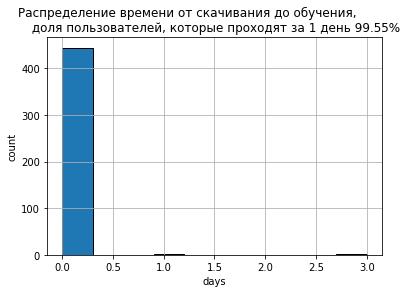

In [20]:
_, ax = plt.subplots()
(inst_learn_delta // np.timedelta64(1,'D')).hist(ec='k')
ax.set_xlabel('days'), ax.set_ylabel('count')
ret = round(100 * np.sum(inst_learn_delta // np.timedelta64(1,'D') == 0) / inst_learn_delta.dropna().shape[0], 2)
ax.set_title(f'Распределение времени от скачивания до обучения,\
              \n доля пользователей, которые проходят за 1 день {ret}%');

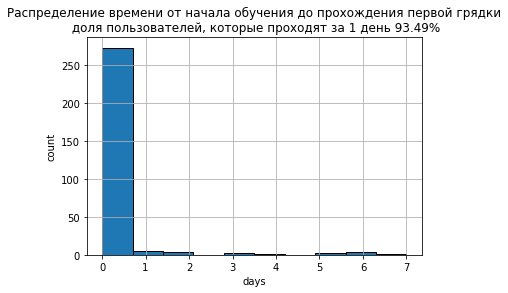

In [21]:
_, ax = plt.subplots()
(learn_glade_delta // np.timedelta64(1,'D')).hist(ec='k')
ax.set_xlabel('days'), ax.set_ylabel('count')
ret = round(100 * np.sum(learn_glade_delta // np.timedelta64(1,'D') == 0) / learn_glade_delta.dropna().shape[0], 2)
ax.set_title(f'Распределение времени от начала обучения до прохождения первой грядки\n доля пользователей, которые проходят за 1 день {ret}%');

Из данных результатов, видно, что пользователи достаточно быстро обучаются и проходят первую грядку.

In [22]:
# построить распределение кол-во подсказок, кол-во уровней при прохождении первой грядки
test_df = pd.merge(dfs['learning'], dfs['gladeComplete'], on='user_id', how='outer')
cur_df = pd.isna(test_df).any(1)
nan_idx = cur_df[cur_df == True]
nona_idx = cur_df[cur_df == False]

learn_nan_count = []
learn_nona_count = []
for i in nan_idx.index.values:
    learn_nan_count += [df[(df['event_name']=='learning') & (df['user_id'] == test_df.iloc[i]['user_id'])].shape[0]]

for i in nona_idx.index.values:
    learn_nona_count += [df[(df['event_name']=='learning') & (df['user_id'] == test_df.iloc[i]['user_id'])].shape[0]]

plot_df = pd.DataFrame({'x': learn_nona_count + learn_nan_count,
                        'finish_glade': ['yes']*len(learn_nona_count) + ['no']*len(learn_nan_count)})

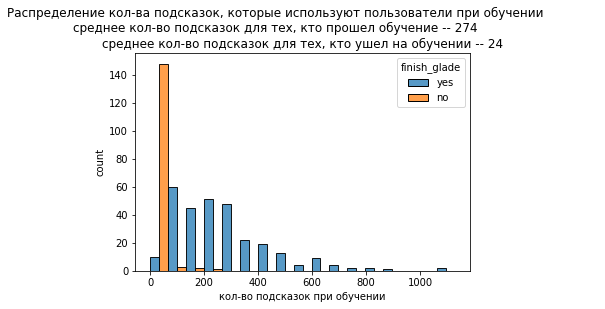

In [23]:
_, ax = plt.subplots()   
sns.histplot(data=plot_df, x='x', hue='finish_glade', ax=ax, multiple="dodge")
ax.set_xlabel('кол-во подсказок при обучении'), ax.set_ylabel('count')
ax.set_title('Распределение кол-ва подсказок, которые используют пользователи при обучении\
              \nсреднее кол-во подсказок для тех, кто прошел обучение -- %d\
              \nсреднее кол-во подсказок для тех, кто ушел на обучении -- %d' % (plot_df[plot_df['finish_glade']=='yes']['x'].mean(),
                                                                                 plot_df[plot_df['finish_glade']=='no']['x'].mean()));

In [24]:
# рассмотрим какие бустеры используют пользователи:
get_dict = lambda x: list(ast.literal_eval(x).values())
boost_data_nan = []
boost_data_nona = []
for i in nan_idx.index.values:
    boost_data_nan += [df[(df['event_name']=='getBooster') & 
                          (df['user_id'] == test_df.iloc[i]['user_id'])]['event_data'].reset_index(drop=True).apply(get_dict)]

for i in nona_idx.index.values:
    boost_data_nona += [df[(df['event_name']=='getBooster') & 
                           (df['user_id'] == test_df.iloc[i]['user_id'])]['event_data'].reset_index(drop=True).apply(get_dict)]

In [25]:
boost_data = {'freeExtraCards':[], 'freeLevels':[], 'freeUndo':[], 'freeWildCard':[], 'finish_glade':[]}

for i, us_id_data in enumerate(boost_data_nona):
    if us_id_data.shape[0] != 0:
        from_l = []
        for k in us_id_data:
            if k[2] == -1:
                from_l += [k[0]]
                
        un_count = np.unique(from_l, return_counts=True)
        try:
            boost_data['freeExtraCards'] += [un_count[1][un_count[0] == 'freeExtraCards'][0]]
        except:
            boost_data['freeExtraCards'] += [0]
        try:
            boost_data['freeLevels'] += [un_count[1][un_count[0] == 'freeLevels'][0]]
        except:
            boost_data['freeLevels'] += [0]
        try:
            boost_data['freeUndo'] += [un_count[1][un_count[0] == 'freeUndo'][0]]
        except:
            boost_data['freeUndo'] += [0]
        try:
            boost_data['freeWildCard'] += [un_count[1][un_count[0] == 'freeWildCard'][0]]
        except:
            boost_data['freeWildCard'] += [0]
        boost_data['finish_glade'] += ['yes']
    else:
        un_count = np.unique(from_l, return_counts=True)
        boost_data['freeExtraCards'] += [0]
        boost_data['freeLevels'] += [0]
        boost_data['freeUndo'] += [0]
        boost_data['freeWildCard'] += [0]
        boost_data['finish_glade'] += ['yes']

for i, us_id_data in enumerate(boost_data_nan):
    if us_id_data.shape[0] != 0:
        from_l = []
        for k in us_id_data:
            if k[2] == -1:
                from_l += [k[0]]
                
        un_count = np.unique(from_l, return_counts=True)
        try:
            boost_data['freeExtraCards'] += [un_count[1][un_count[0] == 'freeExtraCards'][0]]
        except:
            boost_data['freeExtraCards'] += [0]
        try:
            boost_data['freeLevels'] += [un_count[1][un_count[0] == 'freeLevels'][0]]
        except:
            boost_data['freeLevels'] += [0]
        try:
            boost_data['freeUndo'] += [un_count[1][un_count[0] == 'freeUndo'][0]]
        except:
            boost_data['freeUndo'] += [0]
        try:
            boost_data['freeWildCard'] += [un_count[1][un_count[0] == 'freeWildCard'][0]]
        except:
            boost_data['freeWildCard'] += [0]
        boost_data['finish_glade'] += ['no']
    else:
        un_count = np.unique(from_l, return_counts=True)
        boost_data['freeExtraCards'] += [0]
        boost_data['freeLevels'] += [0]
        boost_data['freeUndo'] += [0]
        boost_data['freeWildCard'] += [0]
        boost_data['finish_glade'] += ['no']

boost_data = pd.DataFrame(boost_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



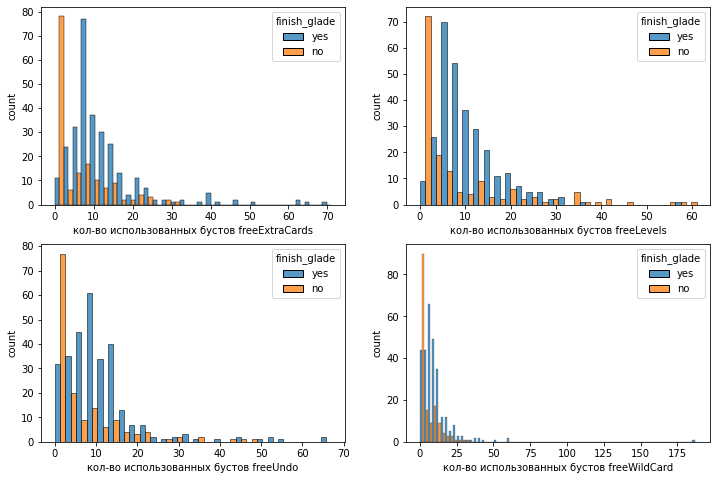

In [26]:
list_x = ['freeExtraCards', 'freeLevels', 'freeUndo', 'freeWildCard']
_, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))   
ax = ax.reshape(-1)
for i in range(4):
    sns.histplot(data=boost_data, x=list_x[i], hue='finish_glade', ax=ax[i], multiple="dodge")
    ax[i].set_xlabel(f'кол-во использованных бустов {list_x[i]}'), ax[i].set_ylabel('count');
# ax.set_title('Распределение кол-ва подсказок, которые используют пользователи при обучении');

In [27]:
boost_data[boost_data['freeWildCard']>150]

,freeExtraCards,freeLevels,freeUndo,freeWildCard,finish_glade
96,33,28,66,188,yes


# Test 1.2 Качество контента (4-5 часов)
Изучите то, как пользователи взаимодействуют с игровыми уровнями. Оцените качество первых 30 уровней игры: какие уровни хороши, какие нет и почему?

In [6]:
level_data = {'id':[], 'stars':[], 'level':[], 'cardsOnField':[], 'cardsOnHands':[], 'time':[], 'win':[]}
for id, user_data in df[df['event_name']=='levelEnd'].groupby(by='user_id'):
    user_data = user_data.sort_values(by='client_time')
    data = user_data['event_data'].reset_index(drop=True).apply(lambda x: json.loads(x))
    for i in data:
        try:
            level = i['levelLoop']
        except:
            continue
        if level in range(0, 31):
            level_data['id'] += [id]
            level_data['level'] += [level]
            level_data['time'] += [i['time']]
            level_data['stars'] += [i['stars']]
            level_data['win'] += [i['win']]
            level_data['cardsOnField'] += [i['cardsOnField']]
            level_data['cardsOnHands'] += [i['cardsOnHands']]

In [7]:
level_data = pd.DataFrame(level_data)
lev_win_data = {'level':[], 'mean_time':[], 'mean_stars':[], 'mean_cardsOnHands':[],
                'VICTORY':[], 'VICTORY_WITH_BOOSTER':[], 'DEFEAT':[], 'NONE':[0], 'DEFEAT_WITH_BOOSTER':[]}
for l, data in level_data.groupby(by='level'): 
    
    lev_win_data['level'] += [l]
    lev_win_data['mean_time'] += [data['time'].mean()]
    lev_win_data['mean_stars'] += [round(data['stars'].mean())]
    lev_win_data['mean_cardsOnHands'] += [round(data['cardsOnHands'].mean())]

    data = data['win'].value_counts()
    for k in ['VICTORY', 'VICTORY_WITH_BOOSTER', 'DEFEAT', 'NONE',
              'DEFEAT_WITH_BOOSTER']:
        try:
            lev_win_data[k] += [data.loc[k]]
        except:
            lev_win_data[k] += [0]
lev_win_data['NONE'] = lev_win_data['NONE'][:-1]
lev_win_data = pd.DataFrame(lev_win_data)

In [8]:
lev_win_data

,level,mean_time,mean_stars,mean_cardsOnHands,VICTORY,VICTORY_WITH_BOOSTER,DEFEAT,NONE,DEFEAT_WITH_BOOSTER
0,0,148279.771345,2,1,1708,7099,3195,0,301
1,1,51789.764881,5,17,330,4,0,288,0
2,5,50147.500000,2,0,0,2,0,2,0
3,6,136419.653968,2,2,259,53,1,0,0
4,7,54194.022654,2,2,260,43,2,2,0
5,8,98549.165563,2,2,273,28,1,4,0
6,9,46237.000000,1,0,2,0,0,0,0
7,10,54226.500000,0,0,0,2,0,0,0
8,11,76381.703333,2,2,267,33,0,0,0
9,12,65582.030405,1,3,277,19,0,0,0


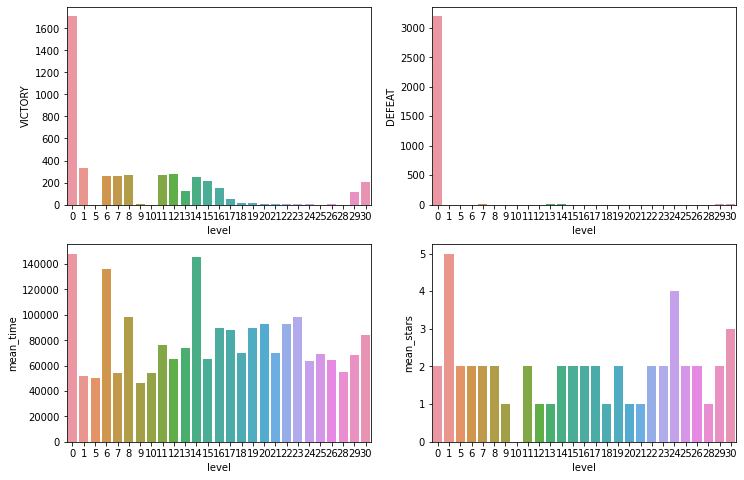

In [9]:
_, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
sns.barplot(x=lev_win_data['level'], y=lev_win_data['VICTORY'], ax=ax[0,0])
sns.barplot(x=lev_win_data['level'], y=lev_win_data['DEFEAT'], ax=ax[0, 1])
sns.barplot(x=lev_win_data['level'], y=lev_win_data['mean_time'], ax=ax[1, 0])
sns.barplot(x=lev_win_data['level'], y=lev_win_data['mean_stars'], ax=ax[1, 1]);

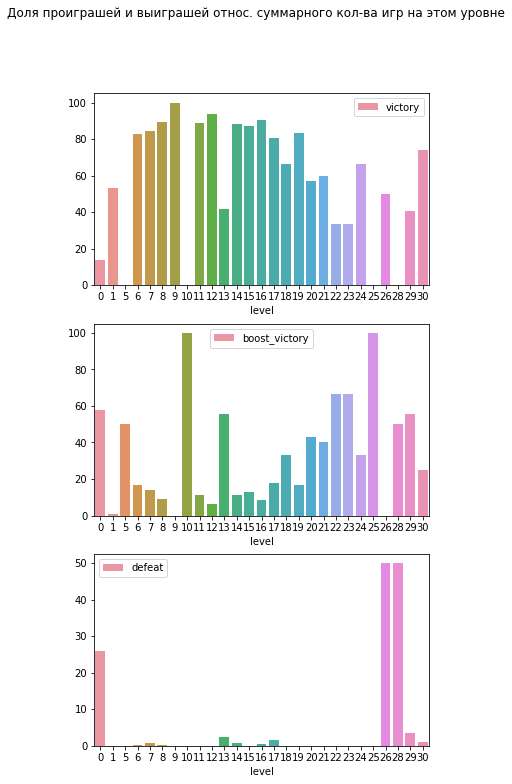

In [16]:
tot_level_game = lev_win_data[['VICTORY',	'VICTORY_WITH_BOOSTER', 'DEFEAT', 'NONE', 'DEFEAT_WITH_BOOSTER']].sum(axis=1)
_, ax = plt.subplots(nrows=3, figsize=(6, 12))
sns.barplot(x=lev_win_data['level'], y=100 * lev_win_data['VICTORY']/tot_level_game, ax=ax[0], label='victory')
sns.barplot(x=lev_win_data['level'], y=100 * lev_win_data['VICTORY_WITH_BOOSTER']/tot_level_game, ax=ax[1], label='boost_victory')
sns.barplot(x=lev_win_data['level'], y=100 * lev_win_data['DEFEAT']/tot_level_game, ax=ax[2], label='defeat')
for i in range(3):
    ax[i].legend()
plt.suptitle('Доля проиграшей и выиграшей относ. суммарного кол-ва игр на этом уровне');

In [11]:
# проверить выигрывают/уходят ли люди после проиграша уровней 13, 29
for id in level_data[(level_data['level']==29) & (level_data['win']=='DEFEAT')]['id'].values:
    print(level_data[level_data['id']==id][['level', 'win']])

    level                   win
31      1               VICTORY
32      6               VICTORY
33      7               VICTORY
34      8               VICTORY
35     11               VICTORY
36     12               VICTORY
37     13  VICTORY_WITH_BOOSTER
38     14               VICTORY
39     15               VICTORY
40     16               VICTORY
41     29                DEFEAT
42     30               VICTORY
      level      win
1341      1  VICTORY
1342      6  VICTORY
1343      7  VICTORY
1344      8  VICTORY
1345     11  VICTORY
1346     12  VICTORY
1347     13   DEFEAT
1348     14  VICTORY
1349     15  VICTORY
1350     16  VICTORY
1351     17  VICTORY
1352     29   DEFEAT
1353     30  VICTORY
      level      win
4453      1  VICTORY
4454      6  VICTORY
4455      7  VICTORY
4456      8  VICTORY
4457     11  VICTORY
4458     12  VICTORY
4459     13   DEFEAT
4460     14  VICTORY
4461     15  VICTORY
4462     16  VICTORY
4463     17  VICTORY
4464     18  VICTORY
4465     29   DEF

Да, люди выигрывают после проиграшей в 13 и 19 уровне, т.е. эти уровни не отбивают у пользователей желание играть, а скорее просто в них чаще допускают ошибки.

In [47]:
# посмотрим сколько уровней прошли те польователи, которые ушли при обучении:
# заводим польный df со всеми уровнями, которые прошел пользователь
level_data_gone = {'id':[], 'stars':[], 'level':[], 'cardsOnField':[], 'cardsOnHands':[], 'time':[], 'win':[]}

# id тех, кто ушел
test_df = pd.merge(dfs['learning'], dfs['gladeComplete'], on='user_id', how='outer')
cur_df = pd.isna(test_df).any(1)
nan_idx = cur_df[cur_df == True].index

for id, user_data in df[df['event_name']=='levelEnd'].groupby(by='user_id'):
    if id in test_df.iloc[nan_idx]['user_id'].values:
        user_data = user_data.sort_values(by='client_time')
        data = user_data['event_data'].reset_index(drop=True).apply(lambda x: json.loads(x))
        for i in data:
            try:
                level = i['levelLoop']
            except:
                continue
            level_data_gone['id'] += [id]
            level_data_gone['level'] += [level]
            level_data_gone['time'] += [i['time']]
            level_data_gone['stars'] += [i['stars']]
            level_data_gone['win'] += [i['win']]
            level_data_gone['cardsOnField'] += [i['cardsOnField']]
            level_data_gone['cardsOnHands'] += [i['cardsOnHands']]

level_data_gone = pd.DataFrame(level_data_gone)
level_data_gone_small = {'id':[], 'level':[], 'mean_time':[], 'mean_stars':[], 'mean_cardsOnHands':[],
                         'VICTORY':[], 'VICTORY_WITH_BOOSTER':[], 'DEFEAT':[], 
                         'NONE':[], 'DEFEAT_WITH_BOOSTER':[]}
for id, data in level_data_gone.groupby(by='id'):
    
    level_data_gone_small['id'] += [id]
    level_data_gone_small['level'] += [data['level'].values]
    level_data_gone_small['mean_time'] += [data['time'].mean()]
    level_data_gone_small['mean_stars'] += [round(data['stars'].mean())]
    level_data_gone_small['mean_cardsOnHands'] += [round(data['cardsOnHands'].mean())]

    data = data['win'].value_counts()
    for k in ['VICTORY', 'VICTORY_WITH_BOOSTER', 'DEFEAT', 'NONE',
              'DEFEAT_WITH_BOOSTER']:
        try:
            level_data_gone_small[k] += [data.loc[k]]
        except:
            level_data_gone_small[k] += [0]

level_data_gone_small = pd.DataFrame(level_data_gone_small)
level_data_gone_small.head()

,id,level,mean_time,mean_stars,mean_cardsOnHands,VICTORY,VICTORY_WITH_BOOSTER,DEFEAT,NONE,DEFEAT_WITH_BOOSTER
0,60ba999a73c31e6a292b7a2b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",45342.214286,2,1,6,6,2,0,0
1,60babef87c80da6a9442cb86,"[1, 6, 7, 13]",44308.250000,3,8,2,2,0,0,0
2,60babfb17c80da6a9442cb87,[1],31960.000000,5,17,1,0,0,0,0
3,60bac42973c31e6a292b7a3a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",123425.211111,2,2,11,77,1,0,1
4,60bace5c7c80da6a9442cb8c,"[0, 0, 0, 0]",19561.750000,3,1,3,1,0,0,0


In [50]:
level_data_gone_small['level'].apply(lambda x: all(x==0)).sum() / level_data_gone_small.shape[0] * 100

60.30534351145038

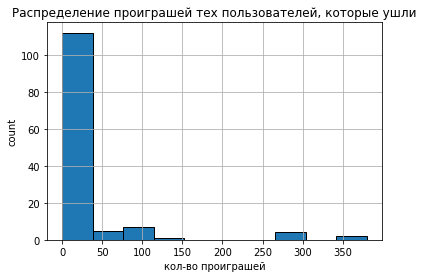

In [46]:
_, ax = plt.subplots()
level_data_gone_small['DEFEAT'].hist(ax=ax, ec='k')
ax.set_xlabel('кол-во проиграшей')
ax.set_ylabel('count')
ax.set_title('Распределение проиграшей тех пользователей, которые ушли');

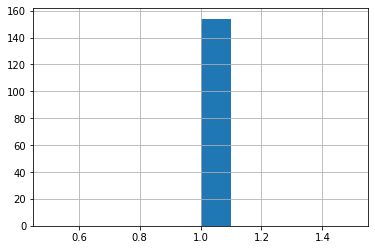

In [48]:
# проверим не перустанавливали пользователи приложение
num_install = {'id':[], 'num':[]}
for id, user_data in df[df['event_name']=='appInstall'].groupby(by='user_id'):
    if id in test_df.iloc[nan_idx]['user_id'].values:
      num_install['id'] += [id]
      num_install['num'] += [user_data.shape[0]]
num_install = pd.DataFrame(num_install)
num_install['num'].hist()

In [ ]:
# todo: Сколько проиграшей сделает пользователь перед тем, как уйдет? 
# (Нужно смотреть дальше, чем 30 уровней и обсудить с командой, что есть уход)

# Test 1.3 Оценка трафика (1 час)
(* Это задание опциональное, его выполнение поможет нам лучше понять ваше
погружение в предметную область и скилы в работе с данными). Часть пользователей в датасете пришли по одной рекламной кампании (media_source
= ad-traffic). Для нее мы знаем CPI:
* CPI = 1,8 USD

Оцените эффективность этой рекламной кампании

$$CPI = \frac{\text{Рекламные расходы}}{\text{количество установок}}$$

In [18]:
tot_num_ad_traffic_users = df[df['media_source']=='ad-traffic']['user_id'].unique().shape[0]

def get_usd(x):
    try :
      y = json.loads(x)['usdProceed']
    except:
      y = json.loads(x)['usdPrice']
    return y

pay_data = {'id':[], 'pay':[]}
for id, user_data in df[(df['event_name']=='transactionComplete') & 
                        (df['media_source']=='ad-traffic')].groupby(by='user_id'):
    pay_data['id'] += [id]
    pay_data['pay'] += [sum(user_data['event_data'].apply(get_usd))]

pay_data = pd.DataFrame(pay_data)

pay_data_organic = {'id':[], 'pay':[]}
for id, user_data in df[(df['event_name']=='transactionComplete') & 
                        (df['media_source']=='organic')].groupby(by='user_id'):
    pay_data_organic['id'] += [id]
    pay_data_organic['pay'] += [sum(user_data['event_data'].apply(get_usd))]

pay_data_organic = pd.DataFrame(pay_data_organic)

In [19]:
# Оценим коэффициент возврата маркетинговых инвестиций
cpi = 1.8
adv_cost = cpi * tot_num_ad_traffic_users
romi = (pay_data['pay'].sum() - adv_cost) / adv_cost * 100
print('total plofit by ad-traffic = %.2f\
      \ntotal plofit by organic = %.2f' % (pay_data['pay'].sum(), pay_data_organic['pay'].sum()))
print('ROMI = %.2f' % romi)

total plofit by ad-traffic = 56.58      
total plofit by organic = 421.92
ROMI = -80.23


In [20]:
adv_cost

286.2

In [329]:
# оценим конверсию в покупку по рекламному каналу
cr = pay_data.shape[0] / tot_num_ad_traffic_users * 100
print('CR = %.2f' % cr)

CR = 4.40
